Code to generate 10,000 random trajectories in an environment with deterministic transitions. Agent has 441 place fields uniformly tiling the square environment and has a single layer of policy weights. 
Weights are optimized by taking the expectation of the policy log likelihood multiplied by the value function which is the cumulative discounted reward. This is converse to the online weight update as by Monte Carlo simulations. 

Simulation is similar to Blake Bordelon 2023 dynamics of TD learning

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from backend import TwoDimNav, PC_AC_agent, plot_maps

In [2]:
random_episodes = 100
test_episodes = 100
tmax = 100

maxspeed = 0.25
goalsize = 0.25
startcoord = [-0.7,-0.7]
goalcoord = [0.7, 0.7]

env = TwoDimNav(startcoord=startcoord, goalcoord=goalcoord, goalsize=goalsize, tmax=tmax, maxspeed=maxspeed)

[-0.7, -0.7]


In [3]:
# initialize agent
nact = 4
gamma = 0.95
npc = 21
pcr = 0.25
seed = 2023

def get_placefield_weights(npc,pcr, nact, seed):
    pcspacing = np.linspace(-1,1,npc) # uniformly space place cells
    pcr =  pcr # define radius of place cells
    xx, yy = np.meshgrid(pcspacing, pcspacing)
    pcs = np.concatenate([xx.reshape(-1,1), yy.reshape(-1,1)],axis=1)
    np.random.seed(seed)
    theta = np.random.normal(size=(npc**2, nact))*1e-3
    return pcs, theta


def get_pc_activity(pcs, pcr, x):
    # convert x,y coordinate to place cell activity
    norm = np.sum((x - pcs)**2,axis=1)
    pcact = np.exp(-norm / (2 * pcr **2))
    return pcact

def softmax(prob):
    return np.exp(prob) / np.sum(np.exp(prob))

def get_action_prob(theta, pcact, beta=2):
    return softmax(beta * np.matmul(theta.T, pcact))

def get_onehot_g(prob, nact=4):
    A = np.random.choice(a=np.arange(nact), p=np.array(prob))
    onehotg = np.zeros(nact)
    onehotg[A] = 1
    return onehotg

def get_discounted_rewards(rewards, gamma=0.95):
    discounted_rewards = []
    cumulative = 0
    for reward in rewards[::-1]:
        cumulative = reward + gamma * cumulative  # discounted reward with gamma
        discounted_rewards.append(cumulative)
    discounted_rewards.reverse()
    return discounted_rewards

pcs, theta = get_placefield_weights(npc, pcr, nact, seed)
inittheta = theta.copy()

In [4]:
def get_coord_reward(param, episodes):
    eps_info = []
    eps_reward = []
    for e in range(episodes):
        state, goal, eucdist, done = env.reset()

        rewards = []
        activities = []

        for t in range(tmax):

            pcact = get_pc_activity(pcs, pcr, state)

            aprob = get_action_prob(param, pcact)
            
            onehotg = get_onehot_g(aprob)

            # eucdist is euclediean distance to goal, done is a sparse scalar reward signal 
            newstate, eucdist, done = env.step(onehotg) 

            rewards.append(int(done))

            # use scalar sparse reward signal to update TD error
            #agent.learn(newstate=newstate, reward=done)

            # get derivatives
            activities.append(np.matmul(pcact[:,None],(onehotg - aprob)[:,None].T))

            #trial_info.append([pcact, aprob, onehotg, int(done)])

            state = newstate.copy()

            if done:
                break
        
        disc_rewards = np.array(get_discounted_rewards(rewards, gamma))[:,None,None]
        grad = np.sum(np.array(activities) * np.array(disc_rewards),axis=0)

        eps_info.append(grad)
        eps_reward.append(np.sum(disc_rewards))
        #print(f'E {e+1}/{train_episodes} in {t} steps')
    return np.array(eps_info), np.array(eps_reward)

In [5]:
# get dataset with 1000 random trajectories, not all are rewarded
episode_info, random_rewards = get_coord_reward(inittheta, random_episodes)
print(np.mean(random_rewards))

7.024766230957152


In [6]:
# Update theta using expectation of random trajectory and rewards, 1 step gradient update
exp_theta = inittheta.copy()
exp_theta += np.mean(episode_info,axis=0)
test_info, exp_rewards = get_coord_reward(exp_theta, test_episodes)
print(np.mean(exp_rewards))

8.13518856885541


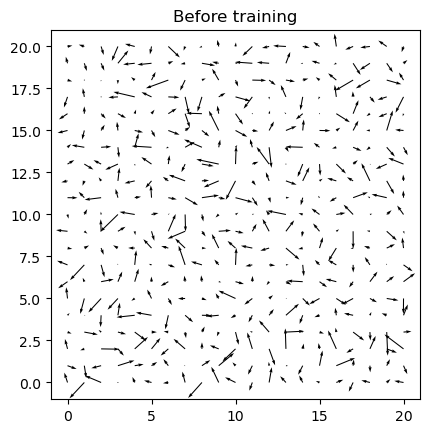

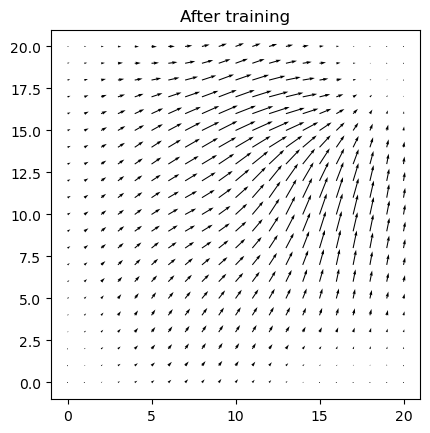

In [7]:
plot_maps(env, npc, inittheta, title='Before training')
plot_maps(env, npc, exp_theta, title='After training')

0.01


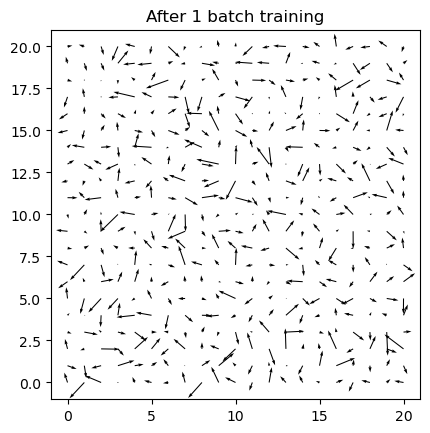

In [8]:
# update theta using non-overlapping batch similar to Bordelon 2023
batch_size = 1
lr = batch_size/random_episodes
print(lr)

batch_theta = inittheta.copy()

batch_idxs = np.random.choice(np.arange(random_episodes), random_episodes, replace=False)
batch_idxs = np.reshape(batch_idxs, (random_episodes//batch_size, batch_size))

batch_rewards = []
for b,batch_idx in enumerate(batch_idxs):
    grads = np.array(episode_info)[batch_idx]
    batch_theta += lr * np.mean(grads,axis=0)
    batch_info, batch_reward = get_coord_reward(exp_theta, test_episodes)
    batch_rewards.append(np.mean(batch_reward))

    if b % 200 == 0:
        plot_maps(env, npc, batch_theta, title=f'After {b+1} batch training')

Text(0, 0.5, 'Cumulative discounted rewards')

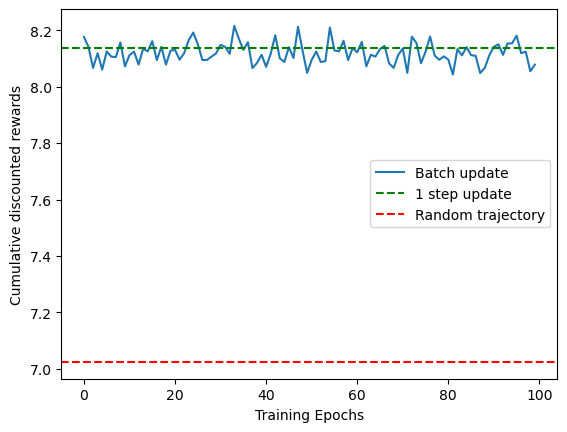

In [9]:
plt.figure()
plt.plot(np.arange(len(batch_idxs)), batch_rewards)
plt.axhline(np.mean(exp_rewards), color='g',linestyle='--')
plt.axhline(np.mean(random_rewards), color='r',linestyle='--')
plt.legend(['Batch update','1 step update','Random trajectory'])
plt.xlabel('Training Epochs')
plt.ylabel('Cumulative discounted rewards')